In [1]:
# !pip install kaggle
# !kaggle datasets download -p dataset/ --unzip cpanag/aifloodsense

In [2]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode
import random
from torch import nn
from tqdm import tqdm
from torchmetrics import JaccardIndex

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
classes_info = pd.DataFrame({
    'class': ['background', 'flood', 'sky', 'building'],
    'grayscale_value': [0, 255, 170, 85],
    'class_index': [0, 1, 2, 3]
})

classes_info

,class,grayscale_value,class_index
0,background,0,0
1,flood,255,1
2,sky,170,2
3,building,85,3


In [5]:
TRAIN_IMAGES_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'train', 'images')
TRAIN_MASKS_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'train', 'masks')
VAL_IMAGES_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'test', 'images')
VAL_MASKS_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'test', 'masks')

In [6]:
for image_name in os.listdir(TRAIN_IMAGES_PATH):
    image_path = os.path.join(TRAIN_IMAGES_PATH, image_name)
    mask_name = image_name.split('.')[0] + '.png'
    mask_path = os.path.join(TRAIN_MASKS_PATH, mask_name)

image_path, mask_path

('dataset/AIFloodSense/AIFloodSense/train/images/157.jpg',
 'dataset/AIFloodSense/AIFloodSense/train/masks/157.png')

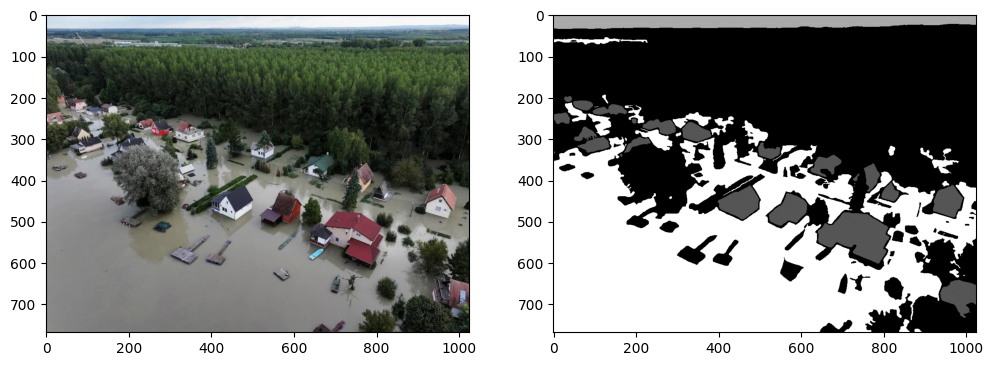

In [7]:
image = Image.open(image_path)
mask = Image.open(mask_path)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')

In [8]:
mask_np = np.array(mask)
np.unique(mask_np)

array([  0,  85, 170, 255], dtype=uint8)

In [9]:
def color_to_index(mask):
    mask_indexes = []

    for color in classes_info['grayscale_value'].values:
        mask_indexes.append(torch.where(mask == color, 1, 0).tolist())

    return torch.tensor(mask_indexes).argmax(dim=0)

In [10]:
color_to_index(torch.tensor(mask_np)).unique()

tensor([0, 1, 2, 3])

In [11]:
IMAGE_SIZE = 224

transforms = {
    'image': v2.Compose([
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.ToDtype(torch.float, scale=True)
    ]),
    'mask': v2.Compose([
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=InterpolationMode.NEAREST_EXACT),
        v2.ToDtype(torch.long, scale=False)
    ])
}

In [12]:
class FloodsDataset(Dataset):
    def __init__(self, images_path, masks_path, transforms):
        super().__init__()
        self.images_pathes = []
        self.masks_pathes = []
        self.transforms = transforms

        for image_name in os.listdir(images_path):
            image_path = os.path.join(images_path, image_name)
            mask_name = image_name.split('.')[0] + '.png'
            mask_path = os.path.join(masks_path, mask_name)
            self.images_pathes.append(image_path)
            self.masks_pathes.append(mask_path)

    def __len__(self):
        return len(self.images_pathes)

    def __getitem__(self, index):
        image_path = self.images_pathes[index]
        mask_path = self.masks_pathes[index]
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        transformed_image = self.transforms['image'](image)
        transformed_mask = self.transforms['mask'](mask)
        indexed_mask = color_to_index(transformed_mask.squeeze())
        return transformed_image, indexed_mask

In [13]:
train_ds = FloodsDataset(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, transforms)
val_ds = FloodsDataset(VAL_IMAGES_PATH, VAL_MASKS_PATH, transforms)
len(train_ds), len(val_ds)

(376, 94)

tensor([0, 1, 2, 3])


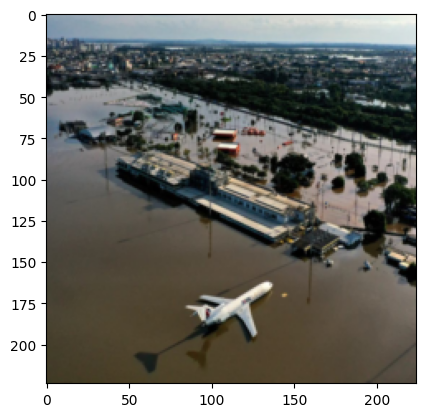

In [14]:
random_index = random.randint(0, len(train_ds) - 1)
random_image = train_ds[random_index][0]
random_mask = train_ds[random_index][1]
print(random_mask.unique())
plt.imshow(random_image.permute(1, 2, 0))


In [15]:
BATCH_SIZE = 16

train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [16]:
for batch in train_loader:
    images = batch[0]
    image_sample = images[0]
    masks = batch[1]
    mask_sample = masks[0]
    break

tensor([0, 1, 3])


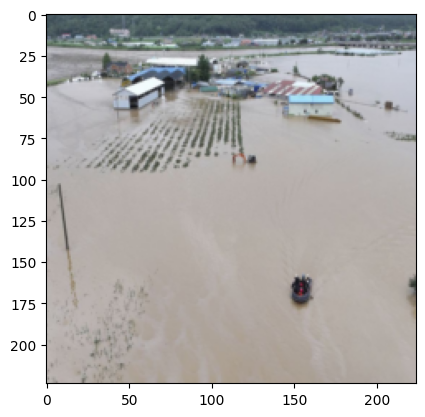

In [17]:
print(mask_sample.unique())
plt.imshow(image_sample.permute(1, 2, 0))

In [18]:
mask_sample.shape

torch.Size([224, 224])

In [19]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu'
device

device(type='cuda')

In [20]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, first_block=False):
        super().__init__()
        if first_block:
            out_channels = 64
        else:
            out_channels = in_channels * 2

        self.act = nn.ReLU()
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding='same')

    def forward(self, batch):
        conv1 = self.conv1(batch)
        conv1 = self.batch_norm(conv1)
        conv1_act = self.act(conv1)
        conv2 = self.conv2(conv1_act)
        conv2 = self.batch_norm(conv2)
        conv2_act = self.act(conv2)
        return conv2_act

In [21]:
class DecoderBlock(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super().__init__()
        in_channels = encoder_channels + decoder_channels
        out_channels = decoder_channels // 2

        self.upconv = nn.ConvTranspose2d(decoder_channels, decoder_channels, 2, 2)
        self.act = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(decoder_channels)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.conv1 = nn.Conv2d(in_channels, decoder_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(decoder_channels, out_channels, 3, padding='same')
        self.conv3 = nn.Conv2d(out_channels, out_channels, 3, padding='same')

    def forward(self, encoder, decoder):
        upconved = self.upconv(decoder)
        concatenated = torch.concat([encoder, upconved], dim=1)
        conv1 = self.conv1(concatenated)
        conv1 = self.batch_norm1(conv1)
        conv1_act = self.act(conv1)
        conv2 = self.conv2(conv1_act)
        conv2 = self.batch_norm2(conv2)
        conv2_act = self.act(conv2)
        conv3 = self.conv3(conv2_act)
        conv3 = self.batch_norm2(conv3)
        conv3_act = self.act(conv3)
        return conv3_act

In [22]:
class CustomUNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.pooling = nn.MaxPool2d(2, 2)
        self.encoder1 = EncoderBlock(3, True)
        self.encoder2 = EncoderBlock(64)
        self.encoder3 = EncoderBlock(128)
        self.encoder4 = EncoderBlock(256)
        self.encoder5 = EncoderBlock(512)
        self.decoder1 = DecoderBlock(512, 1024)
        self.decoder2 = DecoderBlock(256, 512)
        self.decoder3 = DecoderBlock(128, 256)
        self.decoder4 = DecoderBlock(64, 128)
        self.last_conv = nn.Conv2d(64, num_classes, 1)

    def forward(self, batch):
        encoder1 = self.encoder1(batch)
        encoder1_pool = self.pooling(encoder1)
        encoder2 = self.encoder2(encoder1_pool)
        encoder2_pool = self.pooling(encoder2)
        encoder3 = self.encoder3(encoder2_pool)
        encoder3_pool = self.pooling(encoder3)
        encoder4 = self.encoder4(encoder3_pool)
        encoder4_pool = self.pooling(encoder4)
        encoder5 = self.encoder5(encoder4_pool)
        decoder1 = self.decoder1(encoder4, encoder5)
        decoder2 = self.decoder2(encoder3, decoder1)
        decoder3 = self.decoder3(encoder2, decoder2)
        decoder4 = self.decoder4(encoder1, decoder3)
        output = self.last_conv(decoder4)
        return output

In [23]:
# model = CustomUNet(len(classes_info))
# model(batch[0]).shape

In [24]:
# model.to(device)

In [25]:
from torchvision.models import segmentation
from torchvision import models

model = segmentation.deeplabv3_mobilenet_v3_large(num_classes=len(classes_info), 
                                         weights_backbone=models.MobileNet_V3_Large_Weights.DEFAULT)
model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /home/ilya/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:02<00:00, 8.65MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
jaccard_index = JaccardIndex('multiclass', num_classes=len(classes_info)).to(device)

In [27]:
def train(model, loader, loss_fn, optimizer):
    iou_sum = 0
    loss_sum = 0

    model.train()
    for X, Y in tqdm(loader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        output = model(X)['out']
        loss = loss_fn(output, Y)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1)
        iou_sum += jaccard_index(pred, Y).item()
        loss_sum += loss.item()

    return iou_sum / len(loader), loss_sum / len(loader)

In [28]:
def evaluate(model, loader, loss_fn):
    iou_sum = 0
    loss_sum = 0

    with torch.no_grad():
        model.eval()
        for X, Y in tqdm(loader):
            X, Y = X.to(device), Y.to(device)
            output = model(X)['out']
            loss = loss_fn(output, Y)
            pred = output.argmax(dim=1)
            iou_sum += jaccard_index(pred, Y).item()
            loss_sum += loss.item()

    return iou_sum / len(loader), loss_sum / len(loader)

In [29]:
EPOCHS = 20
train_losses = []
train_metrics = []
val_losses = []
val_metrics = []
min_val_loss = None

for epoch in range(1, EPOCHS + 1):
    print('-' * 10)
    print(f'Epoch {epoch}:')
    train_iou, train_loss = train(model, train_loader, loss_fn, optimizer)
    train_metrics.append(train_iou)
    train_losses.append(train_loss)
    print(f'Train IoU: {train_iou}')
    print(f'Train loss: {train_loss}')
    val_iou, val_loss = evaluate(model, val_loader, loss_fn)
    val_metrics.append(val_iou)
    val_losses.append(val_loss)
    print(f'Val IoU: {val_iou}')
    print(f'Val loss: {val_loss}')
    lr_scheduler.step(val_loss)

    if not min_val_loss or min_val_loss > val_loss:
        torch.save(model.state_dict(), 'models/best_params.pt')
        print('Best model saved')

----------
Epoch 1:


100%|██████████| 24/24 [00:24<00:00,  1.04s/it]


Train IoU: 0.4585420998434226
Train loss: 0.7801965624094009


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Val IoU: 0.3808443198601405
Val loss: 0.9461821218331655
Best model saved
----------
Epoch 2:


100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Train IoU: 0.6072472706437111
Train loss: 0.5407415541509787


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Val IoU: 0.45371603469053906
Val loss: 0.8297482033570608
Best model saved
----------
Epoch 3:


100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


Train IoU: 0.6634596685568491
Train loss: 0.46122200042009354


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Val IoU: 0.5133519023656845
Val loss: 0.7305485506852468
Best model saved
----------
Epoch 4:


100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Train IoU: 0.6975763390461603
Train loss: 0.4074418470263481


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Val IoU: 0.5827280382315317
Val loss: 0.6524563729763031
Best model saved
----------
Epoch 5:


100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


Train IoU: 0.7267918040355047
Train loss: 0.3702861654261748


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Val IoU: 0.5894818305969238
Val loss: 0.6659170687198639
Best model saved
----------
Epoch 6:


100%|██████████| 24/24 [00:24<00:00,  1.01s/it]


Train IoU: 0.7405543923377991
Train loss: 0.348063209404548


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Val IoU: 0.5940332015355428
Val loss: 0.6677081982294718
Best model saved
----------
Epoch 7:


100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Train IoU: 0.74972303211689
Train loss: 0.327430909499526


100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Val IoU: 0.6129497687021891
Val loss: 0.6200928886731466
Best model saved
----------
Epoch 8:


100%|██████████| 24/24 [00:25<00:00,  1.05s/it]


Train IoU: 0.7578900009393692
Train loss: 0.3170017935335636


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Val IoU: 0.6213772296905518
Val loss: 0.6221808791160583
Best model saved
----------
Epoch 9:


100%|██████████| 24/24 [00:23<00:00,  1.00it/s]


Train IoU: 0.772994468609492
Train loss: 0.29935652017593384


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Val IoU: 0.6342122256755829
Val loss: 0.5739165792862574
Best model saved
----------
Epoch 10:


100%|██████████| 24/24 [00:24<00:00,  1.01s/it]


Train IoU: 0.7791953335205714
Train loss: 0.2864486053586006


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Val IoU: 0.6027285754680634
Val loss: 0.6003018170595169
Best model saved
----------
Epoch 11:


100%|██████████| 24/24 [00:24<00:00,  1.01s/it]


Train IoU: 0.7772983262936274
Train loss: 0.28522421171267826


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Val IoU: 0.631831039985021
Val loss: 0.5846873968839645
Best model saved
----------
Epoch 12:


100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


Train IoU: 0.7849063848455747
Train loss: 0.28265405260026455


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Val IoU: 0.6229668060938517
Val loss: 0.5790733844041824
Best model saved
----------
Epoch 13:


100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


Train IoU: 0.7927805905540785
Train loss: 0.2688454569627841


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Val IoU: 0.6417821844418844
Val loss: 0.5532159606615702
Best model saved
----------
Epoch 14:


100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Train IoU: 0.7989474112788836
Train loss: 0.26421827139953774


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Val IoU: 0.6453521351019541
Val loss: 0.5495246052742004
Best model saved
----------
Epoch 15:


100%|██████████| 24/24 [00:24<00:00,  1.04s/it]


Train IoU: 0.8032329877217611
Train loss: 0.26007442362606525


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Val IoU: 0.6475597818692526
Val loss: 0.54553751150767
Best model saved
----------
Epoch 16:


100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


Train IoU: 0.8004158983627955
Train loss: 0.2581907498339812


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Val IoU: 0.6498925586541494
Val loss: 0.5446910560131073
Best model saved
----------
Epoch 17:


100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


Train IoU: 0.806301511824131
Train loss: 0.25604513597985107


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Val IoU: 0.6485968430836996
Val loss: 0.5449518412351608
Best model saved
----------
Epoch 18:


100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


Train IoU: 0.8053220411141714
Train loss: 0.25514042874177295


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Val IoU: 0.6505694190661112
Val loss: 0.5438728084166845
Best model saved
----------
Epoch 19:


100%|██████████| 24/24 [00:25<00:00,  1.05s/it]


Train IoU: 0.8039838646848997
Train loss: 0.25652662850916386


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Val IoU: 0.649912824233373
Val loss: 0.5449587553739548
Best model saved
----------
Epoch 20:


100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Train IoU: 0.8063977907101313
Train loss: 0.2549880190442006


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

Val IoU: 0.6489811937014262
Val loss: 0.5460850695768992
Best model saved


In [30]:
lr_scheduler.get_last_lr()

[0.0001]

Text(0.5, 1.0, "IoU's")

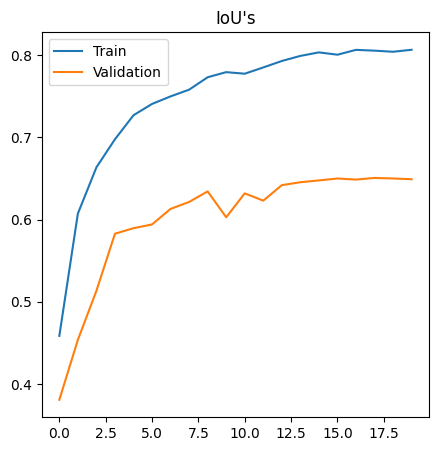

In [31]:
plt.figure(figsize=(5, 5))
plt.plot(train_metrics, label='Train')
plt.plot(val_metrics, label='Validation')
plt.legend()
plt.title('IoU\'s')

Text(0.5, 1.0, 'Losses')

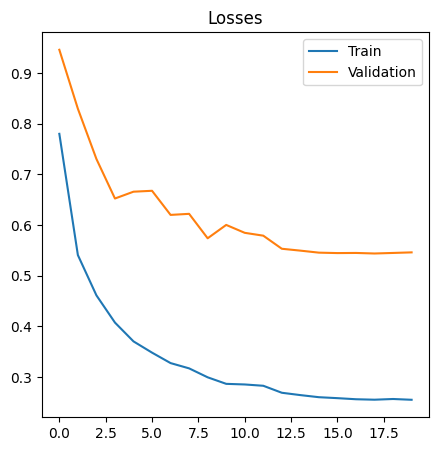

In [32]:
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.title('Losses')

In [38]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu'
model = segmentation.deeplabv3_mobilenet_v3_large(num_classes=len(classes_info))
model.load_state_dict(torch.load('models/best_params.pt', weights_only=True))
model.eval()
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [39]:
def index_to_color(mask):
    mask_colors = []

    for index in range(len(classes_info)):
        color = classes_info[classes_info['class_index'] == index]['grayscale_value'].item()
        mask_colors.append(torch.where(mask == index, color, 0).tolist())

    return torch.tensor(mask_colors).max(dim=0).values

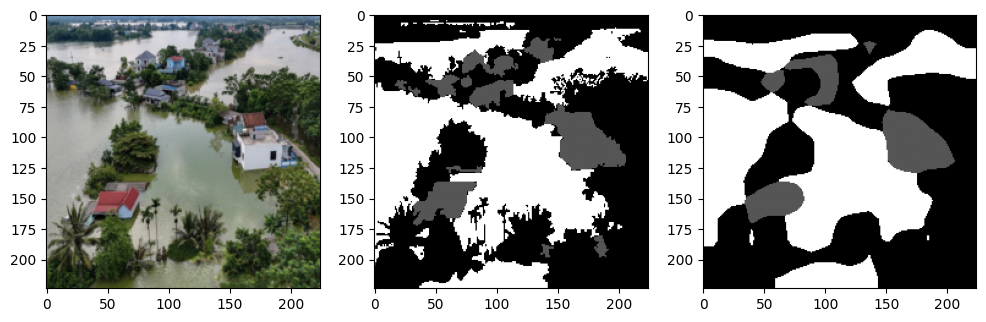

In [40]:
test_index = random.randint(0, len(train_ds) - 1)
test_image = train_ds[test_index][0]
test_mask = train_ds[test_index][1]
test_pred = model(test_image.unsqueeze(0).to(device))['out'][0].argmax(dim=0)
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(index_to_color(test_mask), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(index_to_color(test_pred), cmap='gray')